# MNIST Neural Network From Scratch

The goal of this short project is to train a neural network, using the MNIST dataset, using only linear algebra via Numpy. The MNIST dataset is a collection of 28x28 handwritten digits with corresponding integer values for the represented digit. The model as currently constructed can correctly identify about 90% of hand drawn digits. Using actual data science modules, accuracy well over 98% can be achieved. The data for this project can be accessed __[Here](http://yann.lecun.com/exdb/mnist/)__.

In [129]:
#Import Modules
import numpy as np
#numpy for all data proccessing and modeling
from matplotlib import pyplot as plt
#Pyplot for image generation
from keras.datasets import mnist
#Mnist for loading dataset

In [130]:
#Load adn Reshape data to have 60000 columns of 784 nodes
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = np.reshape(train_X, (60000, 784))
test_X = np.reshape(test_X, (10000, 784))
m, n = train_X.shape
train_X = train_X.T
test_X = test_X.T

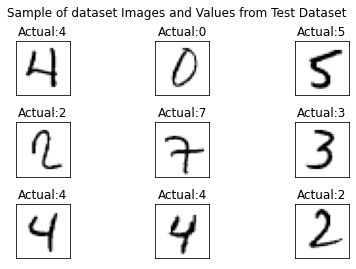

In [173]:
nums = np.random.randint(0, 9999, 9)
plt.figure(1)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[:,nums[i]].reshape(28,28), cmap='Greys')
    plt.yticks([])
    plt.xticks([])
    plt.title('Actual:' + str(test_y[nums[i]]))
plt.suptitle("Sample of dataset Images and Values from Test Dataset", y=1)
plt.subplots_adjust(hspace = .5, wspace = 1.5)

This project uses the sigmoid function as the activator and uses the softmax fuction to generate probabilities and thus predicitons. While there are functions that perform better in training than the sigmoid function, it was selected here for its ability to limit values and prevent them from exceeding the limits of float64.

##### Sigmoid Function:

$$
 h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-P} }  
$$

##### Softmax Function:

$$
\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
$$

In [143]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def sigmoid_deriv(Z):
    dsig = (np.exp(-Z))/((np.exp(-Z)+1)**2)
    dsig = np.nan_to_num(dsig)
    return dsig

def y_col_arr(Y):
    y_col_array = np.zeros((Y.size, Y.max() + 1))
    y_col_array[np.arange(Y.size), Y] = 1
    y_col_array = y_col_array.T
    return y_col_array

def get_predictions(A3, Y):
    predictions = np.argmax(A3,0)
    print('Predictions:')
    print(predictions)
    print('Solutions:')
    print(Y)
    accuracy = np.sum(predictions == Y)/ Y.size
    return accuracy, predictions

In [133]:
def init_params():
    W1 = np.random.rand(72, 784) - 0.5
    b1 = np.random.rand(72, 1) - 0.5
    W2 = np.random.rand(36, 72) - 0.5
    b2 = np.random.rand(36, 1) - 0.5
    W3 = np.random.rand(10, 36) - 0.5
    b3 = np.random.rand(10, 1,) - 0.5
    return (W1, b1, W2, b2, W3, b3)

This neural network utilizes two hidden layers with 72 and 36 nodes respectively. This combination gives a good amount of accuracy without requiring too much time to run.

##### Forward Propogation:

$$
Z^{[1]} = W^{[1]} X + b^{[1]}
$$
$$
A^{[1]} = g_{\text{sigmoid}}(Z^{[1]}))
$$

$$
Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}
$$
$$
A^{[2]} = g_{\text{sigmoid}}(Z^{[2]}))
$$

$$
Z^{[3]} = W^{[3]} A^{[2]} + b^{[3]}
$$
$$
A^{[3]} = g_{\text{softmax}}(Z^{[3]})
$$

##### Backward Propogation:
$$
dZ^{[3]} = A^{[3]} - Y
$$
$$
dW^{[3]} = \frac{2}{m} dZ^{[3]} A^{[2]T}
$$
$$
dB^{[3]} = \frac{2}{m} \Sigma {dZ^{[3]}}
$$

$$
dZ^{[2]} = A^{[2]} - Y
$$
$$
dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}
$$
$$
dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}
$$

$$
dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})
$$
$$
dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}
$$
$$
dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}
$$

##### Update Parameters:
$$
W^{[3]} := W^{[3]} - \alpha dW^{[3]}
$$
$$
b^{[3]} := b^{[3]} - \alpha db^{[3]}
$$

$$
W^{[2]} := W^{[2]} - \alpha dW^{[2]}
$$
$$
b^{[2]} := b^{[2]} - \alpha db^{[2]}
$$

$$
W^{[1]} := W^{[1]} - \alpha dW^{[1]}
$$
$$
b^{[1]} := b^{[1]} - \alpha db^{[1]}
$$

This loops 500 times to appropriately train the model.

In [134]:
def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    return (Z1, A1, Z2, A2, P3, A3)

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    y_col_arr_Y = y_col_arr(Y)
    dZ3 = A3 - y_col_arr_Y
    dW3 = 1/m * dZ3.dot(A2.T)
    db3 = 1/m * np.sum(dZ3)
    dZ2 = W3.T.dot(dZ3) * sigmoid_deriv(Z2)
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * sigmoid_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1)  
    return (dW1, db1, dW2, db2, dW3, db3)

def update_par(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return (W1, b1, W2, b2, W3, b3)

In [144]:
import warnings
    
def gradient_decent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        warnings.filterwarnings('ignore')
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_par(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 5 == 0:
            print("Iterations: ", i)
            accuracy, predictions = get_predictions(A3, Y)
            print(str(accuracy*100) + '%')
            

    return (W1, b1, W2, b2, W3, b3)

In [136]:
W1, b1, W2, b2, W3, b3 = gradient_decent(train_X, train_y, 1, 500)

Iterations:  0
Predictions:
[9 9 9 ... 9 9 6]
Solutions:
[5 0 4 ... 5 6 8]
9.893333333333333%
Iterations:  5
Predictions:
[7 0 4 ... 7 1 4]
Solutions:
[5 0 4 ... 5 6 8]
33.00333333333334%
Iterations:  10
Predictions:
[7 0 4 ... 7 1 6]
Solutions:
[5 0 4 ... 5 6 8]
49.54333333333334%
Iterations:  15
Predictions:
[7 0 4 ... 7 1 4]
Solutions:
[5 0 4 ... 5 6 8]
58.88333333333333%
Iterations:  20
Predictions:
[8 0 4 ... 7 0 6]
Solutions:
[5 0 4 ... 5 6 8]
64.53999999999999%
Iterations:  25
Predictions:
[7 0 4 ... 5 0 4]
Solutions:
[5 0 4 ... 5 6 8]
68.815%
Iterations:  30
Predictions:
[3 0 4 ... 5 0 6]
Solutions:
[5 0 4 ... 5 6 8]
72.15833333333333%
Iterations:  35
Predictions:
[3 0 4 ... 5 6 6]
Solutions:
[5 0 4 ... 5 6 8]
74.66000000000001%
Iterations:  40
Predictions:
[3 0 4 ... 5 6 4]
Solutions:
[5 0 4 ... 5 6 8]
76.77166666666668%
Iterations:  45
Predictions:
[3 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
78.26333333333334%
Iterations:  50
Predictions:
[3 0 4 ... 5 6 8]
Solutions:
[5 0 

Iterations:  445
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.01833333333333%
Iterations:  450
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.06666666666666%
Iterations:  455
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.13166666666666%
Iterations:  460
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.20833333333334%
Iterations:  465
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.24166666666666%
Iterations:  470
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.22%
Iterations:  475
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.31166666666667%
Iterations:  480
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.44166666666666%
Iterations:  485
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.45%
Iterations:  490
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 4 ... 5 6 8]
92.43333333333334%
Iterations:  495
Predictions:
[5 0 4 ... 5 6 8]
Solutions:
[5 0 

92.3% accuracy on training data.

In [175]:
Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, test_X)
accuracy, predictions = get_predictions(A3, test_y)
print(str(accuracy*100) + '%')

Predictions:
[7 2 1 ... 4 5 6]
Solutions:
[7 2 1 ... 4 5 6]
90.85%


90.9% accuracy on test data.

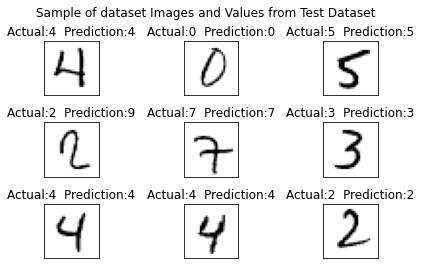

In [174]:
plt.figure(1)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[:,nums[i]].reshape(28,28), cmap='Greys')
    plt.yticks([])
    plt.xticks([])
    plt.title('Actual:' + str(test_y[nums[i]]) + '  Prediction:' + str(predictions[nums[i]]))
plt.suptitle("Sample of dataset Images and Values from Test Dataset", y=1)
plt.subplots_adjust(hspace = .5, wspace = 1.5)

Here you can see examples of the numbers that the model correctly identifies and one example of a 2 which it guesses is a 9. 

By using only numpy, linear algebra, and multivariable calculus this neural network is able to estimate digits from hand drawn images 90.9% of the time. With more tinkering or more training data its possible this neural network could be more accurate, but considering its limited resources 90.9% is a respectable success rate.